<a href="https://colab.research.google.com/github/ivynasantino/vies-discursos-deputados/blob/master/reports/vies_de_discursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Processamento de linguagem natural aplicada à análise de discursos de deputados

Contexto: 
- **Contextualização**: Mediante a vasta quantidade de informação da mídia sobre discussões de projetos de leis, muita das vezes, a população não acompanha o que está sendo discutido de fato no Congresso e, consequentemente desconhece o posicionamento político de um parlamentar. Dessa maneira, a proposta de pesquisa é utilizar os falas dos deputados nas sessões da PEC 06/2019 para detectar de forma automática, utilizando técnicas de NLP o alinhamento e contradição partidária.

- **Objetivo da pesquisa:** Detectar posicionamento político através das discussões realizadas pelos deputados federais.

- **Dados utilizados:** Reunião da CCJC da PEC 06/2019 - Reforma da previdência

- **Onde se encontra o dado:** A Câmara de deputados dispõe de notas taquigrafadas de cada reunião na sua [página](https://www.camara.leg.br/proposicoesWeb/fichadetramitacao?idProposicao=2192459).

- **Ferramentas utilizadas:**
  - [Leg.go](https://leggo.org.br/#/proposicoes) 
  - [PyPdf2](https://pypi.org/project/PyPDF2/)
  - [Raspador de discursos](https://github.com/dados-congresso/raspador-discursos-camara)
  - [Gensim](https://pypi.org/project/gensim/)
  
- **Algoritmos utilizados:** 
  - Word2Vec: utilizado para criar o modelo
  - T-SNE e PCA: responsável por reduzir dimensões do modelo e gerar a visualização
  - Most similar: método do Gensim que mostra as palavra mais similar ao parâmetro pesquisado
  - WMD: utilizado para calcular a distância entre os discursos

In [2]:
# @title Imports
import pandas as pd
import numpy as np
import math 
import operator
import re
import collections

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec

from pyemd import emd

from IPython.display import HTML, display
import tabulate

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Base de dados

In [0]:
# @title Dataframe de discursos
url = "https://raw.githubusercontent.com/ivynasantino/vies-discursos-deputados/master/data/all_discursos.csv"
discursos = pd.read_csv(url)

In [4]:
discursos.head()

,data,autor,partido,uf,discurso
0,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,"Havendo número regimental, declaro aberta a pr..."
1,09/04/2019,AFONSO MOTTA,PDT,RS,"Questão de ordem, Sr. Presidente."
2,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,Questão de ordem do Deputado Afonso Motta.
3,09/04/2019,AFONSO MOTTA,PDT,RS,"Sr. Presidente, o fundamento da minha questão ..."
4,09/04/2019,FELIPE FRANCISCHINI,PSL,PR,"Só um minuto, Deputado. Deputados, por favor, ..."


### Processamento dos dados

- Remover stopwords

In [5]:
nltk.download('stopwords')

# removendo stopwords
default_stopwords = set(stopwords.words('portuguese'))
stopwords_complement = ["","neste","és", "é", "somos", "sois", "são", "era", "eras", "éreis", "foste", "fostes", "foras",	"fôreis",	"serás", "sereis", "serão",	"serias", "seríeis", "sejas", "sejais", "fosses", "fôsseis", "fores", "fordes", "sê", "sejas", "sejais", "ser", "seres", "sermos",	"serdes",	"serem", "sobre", "é"]

stopwords_complement.extend(default_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# @title Importando modelo 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# @title Carregando modelo
model = Word2Vec.load('./drive/My Drive/tcc/tcc/dados/modelo/dados/modelo_tudo/model.txt')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Análises e construção dos docs

- Análise de similaridade e agrupamento de discursos

#### TSNE e PCA

In [0]:
def tsnescatterplot(model, word, list_names):
   
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=12).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


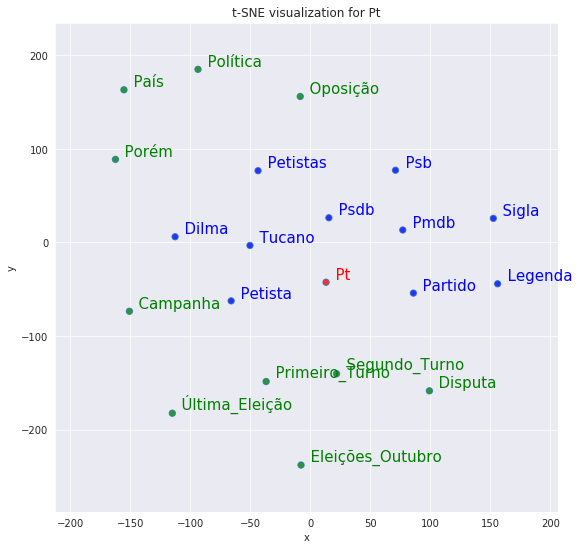

In [11]:
tsnescatterplot(model, 'pt', [t[0] for t in model.wv.most_similar(positive=["eleição"], topn=20)][10:])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


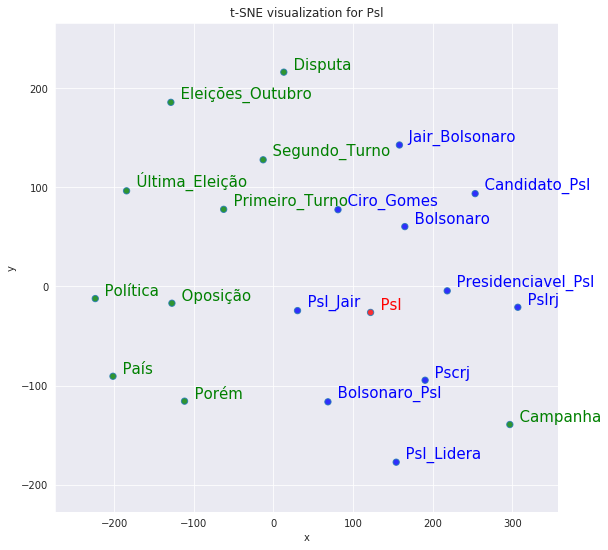

In [12]:
tsnescatterplot(model, 'psl', [t[0] for t in model.wv.most_similar(positive=["eleição"], topn=20)][10:])

In [0]:
def display_table(list_model):
  list_model.insert(0, ("Word", "Most similar"))
  return display(HTML(tabulate.tabulate(list_model, tablefmt='html')))

In [14]:
w1 = ["psl", "eleição"]
psl_eleicao = model.wv.most_similar(positive=w1, topn=15)
display_table(psl_eleicao)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
disputa_presidencial,0.588344931602478
psdb,0.587361752986908
psb,0.5846381783485413
primeiro_turno,0.5844425559043884
pt,0.5711968541145325
eleição_presidencial,0.5704576969146729
segundo_turno,0.5625052452087402
partido,0.5623390674591064
º_turno,0.5591490268707275
candidato,0.5578901767730713


In [15]:
w2 = ["pt", "eleição"]
pt_eleicao = model.wv.most_similar(positive=w2,topn=15)
display_table(pt_eleicao)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
psdb,0.7169778347015381
partido,0.711920440196991
pmdb,0.6996710300445557
dilma,0.6925532817840576
psb,0.6883174180984497
petista,0.6654148697853088
aécio,0.6623741388320923
campanha,0.6600621938705444
eleições,0.6445819139480591
eleição_presidencial,0.6392370462417603


In [16]:
w3 = ["dilma", "pt"]
w4 = ["temer"]
imp = model.wv.most_similar(positive=w3, negative=w4, topn=15)
display_table(imp)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Word,Most similar
petista,0.6747366189956665
aécio,0.6573087573051453
psdb,0.6545529365539551
marina,0.6415231227874756
dilma_rousseff,0.6337395906448364
psb,0.6142704486846924
candidata,0.5955145359039307
partido,0.5933529138565063
tucano,0.5839331150054932
pmdb,0.5768914222717285


### Proximidade de discursos

In [0]:
def discursos_2_array(id_discursos):
    words = re.split(r'\W+', discursos.loc[id_discursos].discurso)
    no_stopwords_discursos = []
    for word in words:
        if word.lower() not in stopwords_complement:
            no_stopwords_discursos.append(word.lower())
    return no_stopwords_discursos

In [0]:
def discursos_2_embeddings(discursos_id):
    words = discursos_2_array(discursos_id)
    
    embed_words = {}
    for word in words:
                
        try:
            embed_words[w] = model[w]
        except:
            continue      
        
    return words, embed_words

In [0]:
def wmdistance(d1, d2):
    d1, d1_embed = discursos_2_embeddings(d1)
    d2, d2_embed = discursos_2_embeddings(d2)
    
    return model.wv.wmdistance(d1, d2)

In [20]:
discursos.discurso.loc[651]

'Sr. Presidente, houve solicitação de alteração da minha inscrição, sou o décimo e alguma coisa, para falar no lugar do Deputado Alencar Santana Braga. Há uma autorização sobre a mesa, Sr. Presidente.'

In [21]:
discursos.discurso.loc[652]

'Tudo bem, Deputado. Vamos aceitar. Com a palavra o Deputado José Guimarães.'

In [22]:
wmdistance(651, 652)

1.1269227889899303

In [0]:
def similarity(discursos_ids):
    score = {}
    for i in range(0, discursos_ids):
        score[i] = wmdistance(discursos_ids, i)
    
    sorted_discursos = sorted(score.items(), key=operator.itemgetter(1))
    return [(i, discursos.loc[i].autor, discursos.loc[i].partido, discursos.loc[i].discurso, "{0:.2f}".format(j)) for i, j in sorted_discursos[1:4]]

In [0]:
def info_disc(discurso_id):
  print(discursos.loc[discurso_id].autor + " (" + discursos.loc[discurso_id].partido + " - " + discursos.loc[discurso_id].uf + ")")
  print(discursos.loc[discurso_id].discurso)

#### Resultados do Word Mover's Distance


In [25]:
info_disc(409)

GERVÁSIO MAIA (PSB - PB)
Sr. Presidente, quero dizer que o requerimento é de nossa autoria. Fizemos um levantamento, nos últimos dias, e constamos o seguinte: em apenas 139 Municípios dos 223 Municípios que tem, o Estado da Paraíba perderá mensalmente 144 milhões de reais Š em apenas 139 Municípios levantados. E são 223 Municípios, repito. Eu quero dizer a esta Comissão que é muito importante que cada Deputado, de cada Estado, faça um levantamento nos seus Municípios. Reunião de: 09/04/2019 Só para se ter uma ideia, Sr. Presidente, o segundo maior Município da Paraíba é o de Campina Grande. Sras. e Srs. Deputados, em Campina Grande, os beneficiários da Previdência recebem mensalmente 90 milhões de reais. Então, 90 milhões de reais por mês vão para os pobres do segundo maior Município do Estado da Paraíba. Se a reforma da Previdência for aprovada, sabem quanto Campina Grande vai perder por mês? Serão 22 milhões de reais, que sairão exatamente das pessoas mais pobres. Um pequeno detalhe:

In [26]:
similarity(409)

[(284,
  'GILSON MARQUES',
  'NOVO',
  'Sr. Presidente, nós vamos encaminhar contra o requerimento porque o Brasil está, sim, no cheque especial, e nós precisamos resolver esse furo. Não vejo soluções para resolvermos o problema da Previdência. Qual seria a solução, então? Imprimir dinheiro? Vai gerar inflação. Vamos deixar as pessoas fazerem empréstimo? O Governo fazer empréstimo? Vamos aumentar os impostos? Todas as soluções são piores do que fazer a reforma da Previdência. E esse papo de dizer que é inconstitucional não cola. O art. 201 da Constituição Federal diz que existe a necessidade de haver um equilíbrio atuarial entre despesa e gasto. Reunião de: 09/04/2019 Além disso, a reforma precisa combater as desigualdades, justamente o que consta lá no art. 3º da Constituição Federal, porque hoje nós temos 40 milhões de pessoas que recebem aposentadoria ou são pensionistas, das quais apenas 1 milhão de pessoas recebem 200 bilhões de reais da Previdência, dos 720 bilhões que se gastam,

In [0]:
similarity(409)

[(284,
  'GILSON MARQUES',
  'NOVO',
  'Sr. Presidente, nós vamos encaminhar contra o requerimento porque o Brasil está, sim, no cheque especial, e nós precisamos resolver esse furo. Não vejo soluções para resolvermos o problema da Previdência. Qual seria a solução, então? Imprimir dinheiro? Vai gerar inflação. Vamos deixar as pessoas fazerem empréstimo? O Governo fazer empréstimo? Vamos aumentar os impostos? Todas as soluções são piores do que fazer a reforma da Previdência. E esse papo de dizer que é inconstitucional não cola. O art. 201 da Constituição Federal diz que existe a necessidade de haver um equilíbrio atuarial entre despesa e gasto. Reunião de: 09/04/2019 Além disso, a reforma precisa combater as desigualdades, justamente o que consta lá no art. 3º da Constituição Federal, porque hoje nós temos 40 milhões de pessoas que recebem aposentadoria ou são pensionistas, das quais apenas 1 milhão de pessoas recebem 200 bilhões de reais da Previdência, dos 720 bilhões que se gastam,

In [0]:
info_disc(273)

ERIKA KOKAY (PT - DF)
Sr. Presidente, o PT quer demonstrar alinhamento à proposta apresentada. Nós estamos lidando com um tema que vai mexer com um número por volta de 100 milhões de brasileiros e brasileiras, inclusive com a população de baixa renda, que pode não ter mais o direito à aposentadoria.


In [27]:
similarity(273)

[(197,
  'GILSON MARQUES',
  'NOVO',
  'Presidente, 56% do Orçamento do Brasil vai para o pagamento da previdência, sendo que só 20% da população recebe esse benefício, ou 40 milhões de pessoas do total de 207 milhões. Existe uma elite que recebe 10% de tudo o que Brasil arrecada. E aí as pessoas dizem:  Quem vai pagar o déficit? Esse déficit é histórico. O PT esteve 18 anos no governo e não fez nada para corrigir isso. O déficit não vem de agora. Já atrasamos muito essa discussão e precisamos ter coragem de enfrentá-la. Por que não hoje? Na semana passada, quando esperávamos aqui o Ministro Guedes, e ele não veio, disseram que ele não tinha coragem, que estávamos retardando o processo. Nós não queremos retardar isso. Vamos, sim, discutir a Previdência agora! Em média, 30 milhões de pessoas recebem 1.450 reais. Essa Previdência é a solidariedade do prejuízo. Precisamos enfrentar esse tema. O Partido Novo vota sim. Reunião de: 09/04/2019',
  '1.03'),
 (177,
  'LUIZÃO GOULART',
  'PRB',


In [0]:
similarity(273)

[(271,
  'MARCELO RAMOS',
  'PR',
  'Presidente, o PR quer apenas manifestar, desde já, alinhamento com a proposta apresentada pelo Deputado Arthur Maia.',
  '3.30'),
 (99, 'FELIPE FRANCISCHINI', 'PSL', 'Aditar?', '3.30'),
 (177,
  'LUIZÃO GOULART',
  'PRB',
  'O PRB, Sr. Presidente, tem se aprofundado no tema da Previdência e reconhece que, mais cedo ou mais tarde, teremos que enfrentar o debate, discutir aprofundadamente o tema. Temos divergências em diversos pontos da proposta inicial, mas consideramos que a discussão tem que ser enfrentada. Nós votamos sim.',
  '3.33')]

In [0]:
info_disc(628)

HENRIQUE FONTANA (PT - RS)
Nós estamos, evidentemente, dentro do acordo de procedimento, mas, como acaba de haver uma orientação, que eu respeito, do Deputado Trad, que, do meu ponto de vista, talvez na empolgação, trouxe o debate sobre o que os Governos Lula e Dilma fizeram em relação à Previdência, eu me sinto instado a fazer esta intervenção neste momento. De fato, nós não somos daqueles que pensam que ou se faz ou não se faz a reforma da Previdência, Deputado Renildo. Tem-se que fazer coisas justas. Por isso nós entendemos que esta proposta que está aqui é de tal maneira cruel e draconiana contra os mais pobres que não serve ao interesse da economia do Brasil nem ao Brasil. Agora, quando introduzimos, por exemplo, o fundo de previdência pública complementar para os novos servidores públicos a partir de 2013, essa reforma respeitou direito adquirido, foi justa socialmente, ajudou a Previdência, ajudou o País. Se fossem propostas coisas como essas, poderíamos fazer reforma de novo, m

In [28]:
similarity(628)

[(607,
  'MARCEL VAN HATTEM',
  'NOVO',
  'Sr. Presidente, eu quero subscrever a defesa feita pelo meu colega, Deputado Gilson Marques, contra este requerimento. Afinal, nós precisamos discutir aqui a Previdência. Parabéns, aliás, Sr. Presidente, pela condução dos trabalhos ontem, apesar de toda a turbulência gerada aqui pela Oposição, que está nesta Casa fazendo um papel que deixa todos os colegas Deputados constrangidos perante a sociedade brasileira. Fazer obstrução é um direito, agora, na forma como estão fazendo, é uma vergonha: fazer leitura de ata, obrigar os Deputados aqui a assistirem a correções  fake  das atas... Isso nos deixa profundamente constrangidos e envergonhados. Não há nada que seja mais prioritário no Brasil do que a reforma da Previdência. O meu colega Gilson Marques foi muito correto. Aqui se trata de discutir a admissibilidade constitucional. Não se trata de mérito. Trata-se de saber se é ou não constitucional a PEC. Ponto. Se querem defender os mais ricos aqui

In [0]:
similarity(628)

[(455,
  'RUBENS BUENO',
  'CIDADANIA',
  'Sr. Presidente, ouvindo o encaminhamento de vários membros desta Comissão, Líderes de bancada, percebo que fica o tempo. E o tempo sempre nos dá a capacidade de pensar nos momentos que passamos aqui. Fernando Henrique, Lula, Dilma, todos tentaram fazer uma reforma. Quando a fizeram, fizeram-na em parte. Michel Temer tentou fazê-la, e, na última hora, não conseguimos realizar a reforma da Previdência. Ela é fundamental para haver equilíbrio fiscal e confiança econômica neste País. E é por aí que nós vamos votar. Por isso, nós não queremos a retirada e votamos não.',
  '3.28'),
 (99, 'FELIPE FRANCISCHINI', 'PSL', 'Aditar?', '3.28'),
 (607,
  'MARCEL VAN HATTEM',
  'NOVO',
  'Sr. Presidente, eu quero subscrever a defesa feita pelo meu colega, Deputado Gilson Marques, contra este requerimento. Afinal, nós precisamos discutir aqui a Previdência. Parabéns, aliás, Sr. Presidente, pela condução dos trabalhos ontem, apesar de toda a turbulência gerada 